# DSCI 512 Lecture 6: Sparse matrices



Outline:

- Graph representations
- Sparse matrices
- Python `map` and `reduce` 
- T/F questions

## Graph representations

In [1]:
import networkx as nx

G = nx.bull_graph()

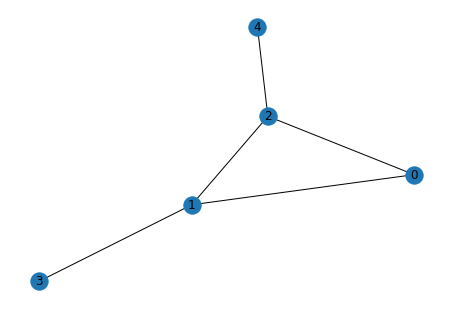

In [3]:
nx.draw(G, with_labels=True)

We can represent the graph as an _adjacency list_. It lists all pairs of vertices that are connected, for example $(0,1)$.

In [4]:
print(G.edges())

[(0, 1), (0, 2), (1, 2), (1, 3), (2, 4)]


Or, we can represent the graph as an _adjacency matrix_. This matrix has size `# vertices` x `# vertices`

In [5]:
adj = nx.adjacency_matrix(G).toarray()
adj

array([[0, 1, 1, 0, 0],
       [1, 0, 1, 1, 0],
       [1, 1, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=int32)

This representation is often nice. For example we can check if any two nodes $i$ and $j$ are connected in $O(1)$ time:

In [6]:
adj[1,3]

1

What is the space complexity of these two representations? Let $E$ be the number of edges and $V$ be the number of vertices. Then

- Adjacency list: $O(E)$
- Adjacency matrix: $O(V^2)$

Question: Which is better?


<span style="background-color:black;">
Answer: the adjacency list seems better. But in the worst case of a complete graph, then $E=O(V^2)$ and the two are about the same. But if $E=O(V)$, say, then the matrix seems very wasteful.

</span>

Wouldn't it be great if we could have the best of both worlds? Enter sparse matrices.



## Sparse matrices

In [7]:
import scipy.sparse

In [8]:
G = nx.ladder_graph(5)

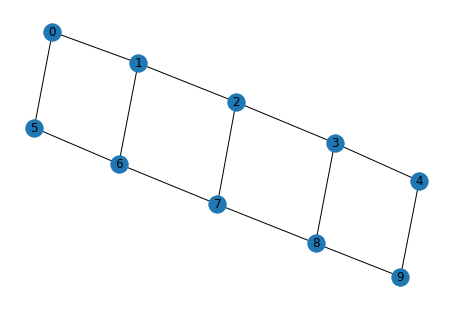

In [9]:
nx.draw(G, with_labels=True)

In [10]:
am_ladder = nx.adjacency_matrix(G)

In [11]:
type(am_ladder)

scipy.sparse.csr.csr_matrix

- Sparse matrices are conceptual data structure like a list, dictionary, set, etc.
- [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html) matrices are the standard Python implementation of this conceptual data structure, like `list`, `dict`, `set`, etc.
- Going to that link, we can see there are many types of scipy sparse matrix.
  - This one is a [`csr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)
  - More later on these types.
- You can convert them to numpy arrays with `toarray()`, but this is usually a bad idea.

In [12]:
print(am_ladder.toarray())

[[0 1 0 0 0 1 0 0 0 0]
 [1 0 1 0 0 0 1 0 0 0]
 [0 1 0 1 0 0 0 1 0 0]
 [0 0 1 0 1 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 1 0 1 0 0]
 [0 0 1 0 0 0 1 0 1 0]
 [0 0 0 1 0 0 0 1 0 1]
 [0 0 0 0 1 0 0 0 1 0]]


In [13]:
G = nx.fast_gnp_random_graph(100000,1e-4) # make a bigger graph with more vertices/edges

In [14]:
am = nx.adjacency_matrix(G)

In [15]:
am.shape

(100000, 100000)

In [16]:
am.nnz

1001272

Stored in full form, the matrix would take up:

In [17]:
import numpy as np

full_size = int(np.prod(am.shape))*8/(1e9)
print("The full matrix would take up %d GB" % full_size)

The full matrix would take up 11 GB


That's a lot! How big is the sparse matrix?

In [18]:
sparse_size = am.data.nbytes/1e6
print("The sparse matrix takes up %d MB" % sparse_size)

The sparse matrix takes up 4 MB


So, the fraction of space saved is:

In [19]:
frac_nz = am.nnz / np.prod(am.shape)
print("The sparse matrix is %dx smaller" % (1/frac_nz))

The sparse matrix is 1408x smaller


- Right, so we definitely don't want to store the full matrix.
- Let's do some operations on the sparse matrix.

Get all neighbours of vertex $i$:

In [20]:
i = 0
print(am[i])

  (0, 9232)	1
  (0, 40150)	1
  (0, 41347)	1
  (0, 42170)	1
  (0, 50825)	1
  (0, 65067)	1
  (0, 66452)	1
  (0, 82621)	1
  (0, 86798)	1
  (0, 89914)	1


- There are some weird things to know about scipy sparse matrices.
- For example, with a regular numpy array, `x[i,j]` and `x[i][j]` are equivalent:

In [21]:
x = np.random.rand(10,10)

In [22]:
x[1,2]

0.7156063748204419

In [23]:
x[1][2]

0.7156063748204419

This is because `x[1]` returns the first row, and then the `[2]` indexes into that row:

In [24]:
x[1]

array([0.27138277, 0.24834617, 0.71560637, 0.13436518, 0.41253745,
       0.53402863, 0.30471054, 0.83003516, 0.6805392 , 0.53538597])

In [25]:
row_1 = x[1]
row_1[2]

0.7156063748204419

However, with `scipy.sparse` matrices, things are a bit different:

In [26]:
from scipy.sparse import csr_matrix,csc_matrix,lil_matrix

x_sparse = csr_matrix(x)

In [27]:
x_sparse[1,2]

0.7156063748204419

In [28]:
x_sparse[1][2]

IndexError: index (2) out of range

Why?

In [29]:
row_1_sparse = x_sparse[1]

In [30]:
row_1_sparse.shape

(1, 10)

- The sparse matrix returns a different shape, leaving in the first dimension.
- This is because sparse matrices must always be 2d
- This can be annoying and is something to watch out for.
- In general, I suggest using the `x[1,2]` notation when possible because chaining the `[]` can be problematic in several places (e.g., also pandas).
- However, this is only for numpy, not, say, a list of lists:

In [31]:
lst = [[1,2,3],[4,5,6],[7,9]]

In [32]:
lst[0][1]

2

In [33]:
lst[0,1]

TypeError: list indices must be integers or slices, not tuple

#### sparse matrix operations

Let's try to find the vertex with the most neighbours:

In [34]:
ind = np.argmax(am.getnnz(axis=0))
val = np.max(am.getnnz(axis=0))

print("Vertex", ind, "has", val, "neighbours")  

Vertex 10229 has 28 neighbours


- Regular numpy functions work on sparse matrices, although they might be fast/slow depending. 
- You definitely do not want to iterate through the rows - make sure you use builtin numpy functions. 

In [35]:
num_rows, num_cols = am.shape

In [36]:
%%timeit -r1 -n1 

# iterate through the rows - this is much slower than numpy functions
for i in range(num_rows):
    am[i,:]

5.33 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [170]:
%%timeit -r1 -n1

# iterate through the columns - this is much MUCH slower
for i in range(num_cols):
    am[:,i]

13min 36s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Above: 

- Looping is slower, as per usual.
- But at least looping through the rows of a `csr_matrix` isn't that bad.
- However, looping through the columns of a `csr_matrix` is a disaster - it took several min on my laptop!!
  - Because it is stored _row by row_. 
  - To grab a single column, it needs to loop through each row and look for items in that column.
- Let's say you really needed a loop (usually not the case!) - then you would first convert the matrix type.

In [37]:
am_csc = am.tocsc()

In [38]:
%%timeit -r1 -n1

for i in range(num_cols):
    am_csc[:,i]

12.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- Note: adjacency matrices are symmetric, so looping through the rows or the columns makes no difference.
- However you often (usually!) have non-symmetric matrices.
- In which case this issue could definitely come up.
- But again, use built-in numpy functions whenever you can!!

#### Sparse datasets

Sparse matrices come up _a lot_ in practice, beyond just adjacency matrices in graphs. For example:

- Word counts: we might represent a document by which words are in it, but only a small fraction of all words would appear in a given document.
- Ratings: we might represent an Amazon item by the user ratings, but only a small fraction of all users have rated a given item.
- Physical processes: in a 2019 Capstone project, students examined images from a particle physics dataset, in which most of the sensors got zero signal.
- etc.

#### Building sparse matrices

To create an empty sparse martrix, just provide the shape as the argument to the constructor

In [90]:
shape = (10,10)
#my code here
x = csr_matrix(shape)
#my code here
x.shape

(10, 10)

 However, this is a bad way to build a sparse matrix of any significant size. In fact, scipy will warn you that it's a very bad idea to try to populate a CSR sparse matrix directly

In [67]:
#my code here
x[5,5] = 1
#my code here

C:\Users\User\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


A better way? Build the matrix in another sparse format, and then convert. Let build a diagonal matrix using the lil (linked list) format, which doesn't support efficient row or column operations like the csr and csc matrices, but does support efficient assignment.

In [91]:
#my code here
x = lil_matrix(shape)
for i in range(shape[0]):
    x[i,i] = 1
    
x = csr_matrix(x)
print(x)
#my code here

  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0


The Scikit learn package, which we will be using extensively for machine learning throughout the program, allows you to create csr sparse matrices from Python dictionaries (using [DictVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html)) and even directly from raw text strings (using [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)).

Let's use DictVectorizer to build a sparse matrix of word counts for the texts of the Brown corpus. First, we create a list of dictionaries, where each dictionary contains the word counts. We can use a Counter object for this.

In [100]:
from nltk.corpus import brown
from collections import Counter

word_counts = []

#my code here

for fileid in brown.fileids():
    word_counts.append(Counter(brown.words(fileid)))

print(word_counts[0])

#my code here
    

Counter({'the': 127, '.': 88, ',': 87, 'of': 65, 'to': 55, 'a': 50, 'and': 40, 'in': 39, '``': 34, "''": 33, 'The': 28, 'that': 28, 'said': 24, 'for': 22, 'be': 21, 'was': 18, 'jury': 17, 'Fulton': 14, 'election': 14, 'will': 14, 'which': 13, 'it': 13, 'is': 12, 'as': 12, 'County': 10, 'by': 10, 'has': 10, 'there': 10, 'his': 10, 'on': 9, 'at': 9, 'would': 9, 'resolution': 9, 'Department': 8, 'funds': 8, 'been': 7, 'this': 7, 'an': 6, 'city': 6, 'It': 6, 'should': 6, 'State': 6, 'state': 6, 'with': 6, 'some': 6, 'new': 6, 'not': 6, 'who': 6, 'bonds': 6, 'Atlanta': 5, 'are': 5, 'have': 5, 'these': 5, 'its': 5, 'work': 5, 'Hartsfield': 5, 'Williams': 5, 'Pelham': 5, 'he': 5, 'Republicans': 5, 'county': 5, 'campaign': 5, 'Monday': 5, 'million': 5, 'issue': 5, 'House': 5, 'school': 5, 'Friday': 4, 'primary': 4, 'no': 4, 'place': 4, 'received': 4, 'voters': 4, "Georgia's": 4, 'or': 4, 'recommended': 4, 'legislators': 4, 'Legislature': 4, 'federal': 4, 'one': 4, 'from': 4, '1': 4, 'night': 4

Then, we apply the vectorizer to convert this to a csr matrix. First, initialize the vectorizer, then use its `fit_transform` method

In [101]:
from sklearn.feature_extraction import DictVectorizer

# my code here
vectorizer = DictVectorizer()
x = vectorizer.fit_transform(word_counts)
# my code here
print(type(x))
print(x.shape)


<class 'scipy.sparse.csr.csr_matrix'>
(500, 56057)


One of the nice things about using a vectorizer is that it automatically indexes the columns for you. The list of columns is in a list which can be accessed with the method `get_feature_names()`. We can use it to access information for particular words

In [102]:
#my code here
x[0,vectorizer.get_feature_names().index("the")]
#my code here

127.0

Exercise: use the csr matrix created above to count the number of words in each document of the Brown

In [103]:
# your code here
words_per_text_matrix = np.sum(x,axis=1)
# your code here
words_per_text_matrix

matrix([[2242.],
        [2277.],
        [2275.],
        [2217.],
        [2244.],
        [2263.],
        [2270.],
        [2187.],
        [2234.],
        [2282.],
        [2259.],
        [2338.],
        [2241.],
        [2329.],
        [2314.],
        [2374.],
        [2293.],
        [2314.],
        [2260.],
        [2317.],
        [2245.],
        [2309.],
        [2327.],
        [2252.],
        [2327.],
        [2278.],
        [2288.],
        [2220.],
        [2349.],
        [2274.],
        [2311.],
        [2323.],
        [2284.],
        [2235.],
        [2217.],
        [2229.],
        [2324.],
        [2221.],
        [2452.],
        [2340.],
        [2313.],
        [2338.],
        [2291.],
        [2277.],
        [2200.],
        [2234.],
        [2244.],
        [2230.],
        [2241.],
        [2231.],
        [2239.],
        [2395.],
        [2312.],
        [2298.],
        [2293.],
        [2296.],
        [2267.],
        [2264.],
        [2311.

Note that when you do an operation which removes one of the dimensions, you actually don't have a sparse matrix anymore. Surprisingly, you also don't have a numpy array. Instead, you have a numpy [matrix](https://docs.scipy.org/doc/numpy/reference/generated/numpy.matrix.html), which is distinct from an array. See [here](https://numpy.org/devdocs/user/numpy-for-matlab-users.html#array-or-matrix-which-should-i-use) for a discussion of the differences between arrays and matrices. Rule of thumb: (non-sparse) matrices will cause you headaches and you should stay away from them. You can access an array version of the matrix (without copying it) using `np.asarray`, and you should probably do that right away

In [104]:
words_per_text_array = np.asarray(words_per_text_matrix)


An example of where a numpy matrix will cause you trouble: operations like `flatten` (which is suppose to reduce a dataset to 1 dimension) won't work properly with a matrix, which is *always* 2-d

In [105]:
words_per_text_matrix.flatten()

matrix([[2242., 2277., 2275., 2217., 2244., 2263., 2270., 2187., 2234.,
         2282., 2259., 2338., 2241., 2329., 2314., 2374., 2293., 2314.,
         2260., 2317., 2245., 2309., 2327., 2252., 2327., 2278., 2288.,
         2220., 2349., 2274., 2311., 2323., 2284., 2235., 2217., 2229.,
         2324., 2221., 2452., 2340., 2313., 2338., 2291., 2277., 2200.,
         2234., 2244., 2230., 2241., 2231., 2239., 2395., 2312., 2298.,
         2293., 2296., 2267., 2264., 2311., 2260., 2288., 2194., 2287.,
         2299., 2278., 2294., 2357., 2346., 2368., 2316., 2262., 2415.,
         2320., 2356., 2342., 2398., 2433., 2421., 2351., 2345., 2461.,
         2480., 2342., 2282., 2574., 2503., 2311., 2370., 2213., 2334.,
         2332., 2318., 2410., 2317., 2359., 2332., 2314., 2238., 2304.,
         2307., 2236., 2276., 2315., 2451., 2343., 2258., 2279., 2257.,
         2295., 2271., 2222., 2370., 2226., 2476., 2402., 2333., 2288.,
         2261., 2346., 2333., 2223., 2244., 2302., 2260., 2251.,

But this will work fine with the array version

In [106]:
words_per_text_array.flatten()

array([2242., 2277., 2275., 2217., 2244., 2263., 2270., 2187., 2234.,
       2282., 2259., 2338., 2241., 2329., 2314., 2374., 2293., 2314.,
       2260., 2317., 2245., 2309., 2327., 2252., 2327., 2278., 2288.,
       2220., 2349., 2274., 2311., 2323., 2284., 2235., 2217., 2229.,
       2324., 2221., 2452., 2340., 2313., 2338., 2291., 2277., 2200.,
       2234., 2244., 2230., 2241., 2231., 2239., 2395., 2312., 2298.,
       2293., 2296., 2267., 2264., 2311., 2260., 2288., 2194., 2287.,
       2299., 2278., 2294., 2357., 2346., 2368., 2316., 2262., 2415.,
       2320., 2356., 2342., 2398., 2433., 2421., 2351., 2345., 2461.,
       2480., 2342., 2282., 2574., 2503., 2311., 2370., 2213., 2334.,
       2332., 2318., 2410., 2317., 2359., 2332., 2314., 2238., 2304.,
       2307., 2236., 2276., 2315., 2451., 2343., 2258., 2279., 2257.,
       2295., 2271., 2222., 2370., 2226., 2476., 2402., 2333., 2288.,
       2261., 2346., 2333., 2223., 2244., 2302., 2260., 2251., 2239.,
       2402., 2307.,

## Python `map` and `reduce`

- You may hear about [MapReduce](https://en.wikipedia.org/wiki/MapReduce) in the context of big data.
- We won't get into details here, but at least we will introduce `map` and `reduce`.
- You also saw these in DSCI 511 (the R part), we'll go into slightly more detail and do it in Python.

#### `map`

In [68]:
def times_two(x):
    return x*2

data = [1,2,3,4]

In [69]:
map(times_two, data)

- In more recent versions of Python, `map` returns a map object which is essentially a generator.
- The idea is that you might not want to store the results in memory, you probably just want to iterate through them.

In [70]:
result = map(times_two, data)

In [71]:
result[2]

TypeError: 'map' object is not subscriptable

In [72]:
next(result)

2

In [73]:
next(result)

4

You can explicitly cast the result to a list: 

In [74]:
list(map(times_two, data))

[2, 4, 6, 8]

But often this is unnecessary and just takes up more time/memory for no reason.

- You will see something similar to `map` going by many names, like `apply` in pandas. In R there is also `purrr:map`. 
- All of these have the same idea: apply a function to each element of a list.
- Or in fact it doesn't even have to be a list, it could be a generator:

In [75]:
result = map(times_two, map(times_two, data))

In [76]:
list(result)

[4, 8, 12, 16]

Here, we applied `map` to a map object. This is already an example of the interchangeable nature of lists and generators. 

Note: you'll often see people using `lambda` functions inline, as in:

In [77]:
list(map(lambda x: x*2, data))

[2, 4, 6, 8]

This is more convenient than actually naming a function `times_two` in cases where the function serves no other purpose than this.

#### `reduce`

In [78]:
from functools import reduce

- Another common operation is to reduce, or aggregate, data.
- Examples: sum, max

In [79]:
data

[1, 2, 3, 4]

In [80]:
sum(data)

10

In [81]:
max(data)

4

- Underlyingly, in these functions the data are aggregated **pairwise**. 
- That is, $1+2+3-5=((1+2)+3)-5$
- And $\max\{1,2,3,-5\}=\max\{\max\{\max\{1,2\},3\},-5\}$

In [67]:
reduce(lambda x, y: x+y, data)

10

Conveniently, `reduce` can take in a generator as the data, so it can be coupled effectively with `map`. For example, if we want to multiply all the numbers by $2$ and then add them together:

In [82]:
# my code here
reduce(lambda x, y: x+y, map(lambda x: x*2, data))
# my code here

20

`reduce` and recursion:

- We tend to think of these functions recursively, especially `reduce`. 
- In fact, here is an implementation of `reduce`:

In [70]:
def my_reduce(func, data):
    if len(data) == 1:
        return data[0]
    
    # Apply the function to the first two elements 
    new_element = func(data[0],data[1])

    # Concatenate the new element and the rest of the list
    new_list = [new_element] + data[2:]
    
    # Recursively reduce on the new list
    return my_reduce(func, new_list)

In [71]:
my_reduce(lambda x, y: x+y, data)

10

- The ideas of data aggregation and recursion are tied together.
- You just need to define an aggregration operation on two elements, then apply recursively. 

Summary:

| Python name | Other names | Inputs      |  Outputs |
|-------------|-------------|-------------|----------|
|   `map`     |   apply     | a function of one argument and a list/iterable | a new list/iterable with the function applied to each element |
| `reduce`    | aggregate  | a function of two arguments and a list/iterable | a single value with the function applied recursively to pairs of elements |


Exercise: Implement `reduce(lambda x, y: x+y, map(lambda x: x*2, data))` in a single line of code without using any of `map`, `reduce` or `lambda`. Do you think this still MapReduce?

In [83]:
# your code here
sum([x**2 for x in data])
# your code here

30

## T/F questions

1. For a graph with $E$ edges, the adjacency matrix is an $E\times E$ matrix.
2. Adjacency matrices of graphs are always sparse.
3. The `x[i][j]` and `x[i,j]` formats for accessing the contexts of matricies are basically interchangeable
4. If you have to `reduce` data contained in columns of a sparse matrix, you should use CSR format sparse matrices
5. It is reasonable to use the same function `f` with both `map` and `reduce`.